# Lunar Lander Deep-single-q and double-q networks

In [1]:
import gym
import os
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
import atari_py
import matplotlib.pyplot as plt

max_epochs = 200
mem_size = 4000
batch_size = 100
blank = 20

LAYER_1 = 128
LAYER_2 = 64
ALPHA = 0.002
GAMMA = 0.99
SAVE = max_epochs
LOAD = max_epochs

env = gym.make("SpaceInvaders-v0")

Using TensorFlow backend.


Memory buffer to store experiences

In [2]:
from collections import deque

class Memory:
    def __init__(self, size, samplesize):
        self.samplesize = samplesize
        self.memory = deque(maxlen=size)
        self.size = size
    
    def remember(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        indecies = np.random.choice(np.arange(self.size), size=self.samplesize, replace = False)
        return [self.memory[index] for index in indecies]       

In [3]:
class State:
    def __init__(self, resolution_x, resolution_y, size):
        self.frames = deque([np.zeros((resolution_x,resolution_y), dtype=np.int) for i in range(size)], maxlen=size)
    
    def crop(self, state):
        self.frame = state[27:-14, 20:-20]
        self.frame = np.dot(self.frame[...,:3], [0.33, 0.33, 0.33])
        return self.frame
    
    def add(self, state, isnew=False):
        frame = self.crop(state)
        if isnew:
            self.frames.append(frame)
            self.frames.append(frame)
            self.frames.append(frame)
        
        self.frames.append(frame)
    
    def get_state(self):
        return np.stack(self.frames, axis=2)

# Simple q learning agent

In [4]:
class Agent_q:
    def __init__(self, state_dim, action_dim, name = 'qnn'):
        with tf.variable_scope(name):         

            self.state = tf.placeholder(tf.float32, [None, *state_dim], name = 'state')
            self.action = tf.placeholder(tf.int32, [None], name = 'action')
            
            self.conv1 = tf.layers.conv2d(inputs = self.state, filters = 32, kernel_size = [8,8], strides = [4,4], padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name = "conv1")
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1, training = True, epsilon = 1e-5, name = 'batch_norm1')
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out, filters = 64, kernel_size = [4,4], strides = [2,2], padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name = "conv2")
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2, training = True, epsilon = 1e-5, name = 'batch_norm2')
            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out, filters = 128, kernel_size = [4,4], strides = [2,2], padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), name = "conv3")
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3, training = True, epsilon = 1e-5, name = 'batch_norm3')
            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")

            self.flatten = tf.layers.flatten(self.conv3_out)
            
            self.first_layer = tf.contrib.layers.fully_connected(self.flatten, 1024)
            self.second_layer = tf.contrib.layers.fully_connected(self.first_layer, 512)
            
            self.q_vector = tf.contrib.layers.fully_connected(self.second_layer, action_dim, activation_fn = None)
            
            encoded_action_vector = tf.one_hot(self.action, action_dim)
            
            self.target_q_value = tf.placeholder(tf.float32, [None], name = 'target_q_value')
            q_value = tf.reduce_sum(tf.multiply(self.q_vector, encoded_action_vector), axis = 1)

            self.loss = tf.reduce_mean(tf.square(self.target_q_value - q_value))
            self.optimizer = tf.train.AdamOptimizer(ALPHA).minimize(self.loss)
             
    def predict(self, state):
        feed_dict = {self.state : np.array([state])} 
        q_vector = sess.run(self.q_vector, feed_dict = feed_dict)
        return np.argmax(q_vector)
        
    def train(self, experiences):    
        state, action, reward, next_state, done = zip(*experiences)
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        mask = np.array(done)
        
        
        next_q_vector = sess.run(self.q_vector, feed_dict = { self.state : next_state })
        target_q_value = reward + GAMMA * mask * np.max(next_q_vector, axis = 1)
        sess.run([self.loss, self.optimizer],
                 feed_dict = { self.state          : state,
                               self.target_q_value : target_q_value,
                               self.action         : action })

A function to test an agent on the environment

In [5]:
def playtest(env, agent):
    rewards = 0
    stacked_state = State(169, 210, 4)
    state = env.reset()
    stacked_state.add(state, True)
    
    done = False
    rewards = 0
    while not done:
        action = agent.predict(stacked_state.get_state())
        env.render()
        next_state, reward, done, _ = env.step(action)
        rewards+=reward
        if done:
            env.close()
            return rewards
        else:
            state = next_state
            stacked_state.add(state)
            

In [6]:
def test_run(env, agent, update=False):
    memory = Memory(mem_size,batch_size)
    stacked_state = State(169, 210, 4)    
    epsilon = 1
    epsilon_decay = 0.9
    rewards = 0
    print("Prepopulating memory:")
    print("____________________")
    
    state = env.reset()
    stacked_state.add(state, True)
    
    for step in range(mem_size):
        if step%(mem_size/blank)==0:
            print("|", end='')
        action = env.action_space.sample()
        
        next_state, reward, done, _ = env.step(action)
        current_state = stacked_state.get_state()
        stacked_state.add(next_state)
        next_stacked_state = stacked_state.get_state()
        
        memory.remember((current_state, action, reward, next_stacked_state, 1-done))
        if done:
            state = env.reset()
            stacked_state.add(state, True)
        else:
            state = next_state
     
    av_reward = []     
    env.reset()
    print("\nTraining:")
    print("____________________")
    for epoch in range(1,max_epochs+1):
        done = False
        state = env.reset()
        stacked_state.add(state, True)
        
        while not done:
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = agent.predict(stacked_state.get_state())
                
            next_state, reward, done, _ = env.step(action)
            current_state = stacked_state.get_state()
            stacked_state.add(next_state)
            next_stacked_state = stacked_state.get_state()
            
            memory.remember((current_state, action, reward, next_stacked_state, 1-done))
            agent.train(memory.sample())
            if done:
                if epsilon > 0.12:
                    epsilon*=epsilon_decay
                if epoch%(max_epochs/blank)==0:
                    print("|", end='')
                    saver.save(sess, "./DQN/model")
                    rewards+=playtest(env, agent)
                    av_reward.append(rewards/(epoch/(max_epochs/blank)))
                break
            else:
                state = next_state
    return av_reward

Prepopulating memory:
____________________
||||||||||||||||||||
Training:
____________________
||||||||||||||||||||

Text(0,0.5,'Average Reward')

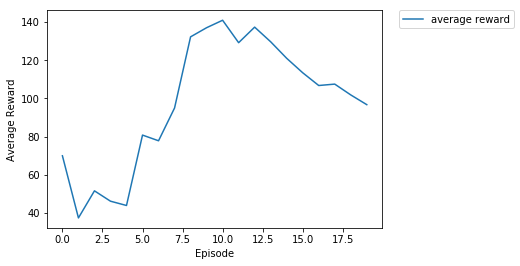

In [7]:
tf.reset_default_graph()
agent_q = Agent_q([169,120,4], env.action_space.n)
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rewards_single = test_run(env, agent_q)


plt.plot(rewards_single, label = "average reward")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Episode')
plt.ylabel('Average Reward')

In [9]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./DQN/model")
    print(playtest(env, agent_q))

INFO:tensorflow:Restoring parameters from ./DQN/model
0.0
